# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, … Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

In [80]:
from easydict import EasyDict as edict
import pandas as pd
import json
import folium
import matplotlib.pyplot as plt

TOPO_FOLDER = './topojson/'
DATA_FOLDER = './data/'

Here we load the topological data as well as the unemployment rates data from EuroStat, we kept only the dataset with respect to active population (and not the one with respect to the total population) simply because data for Switzerland are only available for the former case.

In [146]:
# eu data by active population
eu_total_unemployment_rate = pd.read_excel(DATA_FOLDER + 'eu_total_unemployment_rate_active.xls', na_values=':', header=3)
eu_total_unemployment_rate = eu_total_unemployment_rate.filter(regex=("^((?!Unnamed).)*$"))
eu_total_unemployment_rate.rename(columns={"geo\\time": "country_code"}, inplace=True)

# ch data by active population
ch_total_unemployment_rate = pd.read_excel(DATA_FOLDER + 'ch_total_unemployment_rate_active.xlsx', header=1)
ch_total_unemployment_rate = ch_total_unemployment_rate.reset_index()[['index', 'Taux de chômage']]
ch_total_unemployment_rate.rename(columns={"index": "canton", "Taux de chômage": "rate"}, inplace=True)

# ch data by pourcentage of men
ch_total_unemployment_rate_by_sex = pd.read_excel(DATA_FOLDER + 'ch_total_unemployment_rate_by_sex.xlsx', header=1)
ch_total_unemployment_rate_by_sex = ch_total_unemployment_rate_by_sex.reset_index()[['level_0', 'level_1', 'Taux de chômage']]
ch_total_unemployment_rate_by_sex.rename(columns={"level_0": "canton", "level_1": "sex", "Taux de chômage": "rate"}, inplace=True)
ch_total_unemployment_rate_by_sex["men pourcentage"] = ch_total_unemployment_rate_by_sex.groupby("canton")["rate"].apply(lambda x: x*100/x.sum())
ch_total_unemployment_rate_by_sex = ch_total_unemployment_rate_by_sex[ch_total_unemployment_rate_by_sex["sex"] == "Hommes"].reset_index()[["canton", "men pourcentage"]]

# ch data by pourcentage of foreign
ch_total_unemployment_rate_by_nationality = pd.read_excel(DATA_FOLDER + 'ch_total_unemployment_rate_by_nationality.xlsx', header=1)
ch_total_unemployment_rate_by_nationality = ch_total_unemployment_rate_by_nationality.reset_index()[['level_0', 'level_1', 'Taux de chômage']]
ch_total_unemployment_rate_by_nationality.rename(columns={"level_0": "canton", "level_1": "nationality", "Taux de chômage": "rate"}, inplace=True)
ch_total_unemployment_rate_by_nationality['foreign pourcentage'] = ch_total_unemployment_rate_by_nationality.groupby("canton")["rate"].apply(lambda x: x*100/x.sum())
ch_total_unemployment_rate_by_nationality = ch_total_unemployment_rate_by_nationality[ch_total_unemployment_rate_by_nationality["nationality"] == "Etrangers"].reset_index()[["canton", "foreign pourcentage"]]

# ch data by age group, 15-24 25-49 50 and more
ch_total_unemployment_rate_by_ages = pd.read_excel(DATA_FOLDER + 'ch_total_unemployment_rate_by_ages.xlsx', header=2)
ch_total_unemployment_rate_by_ages = ch_total_unemployment_rate_by_ages.drop(['Unnamed: 2', 'Mois', 'Total', 'Total.1'], axis=1)
ch_total_unemployment_rate_by_ages = ch_total_unemployment_rate_by_ages.drop(0)
ch_total_unemployment_rate_by_ages.columns = ['canton', 'age_group', 'rate', 'total']
ch_total_unemployment_rate_by_ages.dropna(how='any', axis=0, inplace=True)
class_to_age = {1.0: '15-24', 2.0: '25-49', 3.0: '50+'}
ch_total_unemployment_rate_by_ages['age_group'] = ch_total_unemployment_rate_by_ages['age_group'].apply(lambda x: class_to_age[x])
ch_total_unemployment_rate_by_ages.reset_index(inplace=True) 
ch_total_unemployment_rate_by_ages.rate = ch_total_unemployment_rate_by_ages.rate.apply(lambda x: x.replace("'", ''))
ch_total_unemployment_rate_by_ages.total = ch_total_unemployment_rate_by_ages.total.astype(int)
ch_total_unemployment_rate_by_ages.rate = ch_total_unemployment_rate_by_ages.rate.astype(float)



### From there, get the most recent year available for each country

In [83]:
#eu_total_unemployment_rate_active = eu_total_unemployment_rate_active[['country_code', '2016']]
#eu_total_unemployment_rate_total = eu_total_unemployment_rate_total[['country_code', '2016']]

def most_recent_available(row):
    for rate in reversed(row):
        if rate: # if not NaN
            return pd.Series({'country_code': row['country_code'], 'rate': rate})

eu_total_unemployment_rate = eu_total_unemployment_rate.apply(most_recent_available, axis=1)

# We will complete the data with the last missing value: Switzerland
# https://www.amstat.ch/seco/pressedoku/201701_Leporello_fr.pdf
eu_total_unemployment_rate.loc[eu_total_unemployment_rate.country_code == 'CH', 'rate'] = 3.7

## European unemployment rate for active population, by country

In [85]:
m = folium.Map([55, 16], tiles='cartodbpositron', zoom_start=3)

m.choropleth(
    geo_data=open(TOPO_FOLDER + 'europe.topojson.json'),
    data=eu_total_unemployment_rate,
    columns=['country_code', 'rate'],
    key_on='feature.id',
    topojson='objects.europe',
    fill_color='OrRd',
    fill_opacity=0.6,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Unemployment Rate (%)',
    smooth_factor=1.3)

m

The scale defaults to the following quantiles: [0, 0.5, 0.75, 0.85, 0.9], dividing the population in 6 equally-sized categories.

We clearly see that the most impacted countries by the unemployment curse are the southern countries, especially the ones situated on the west side of Europe such as Italy, Spain, Portugal.
We can also notice that eastern countries go well in term of unemployment rate, with the exception onf Turkey, with <6% on average, oscillating between lowest and second-lowest quantiles.

## Swiss unemployment rate for active population, by canton

In [55]:
m = folium.Map([46.9182, 8.2275], tiles='cartodbpositron', zoom_start=8)

m.choropleth(
    geo_data=open(TOPO_FOLDER + 'ch-cantons.topojson.json'),
    data=ch_total_unemployment_rate,
    columns=['canton', 'rate'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='OrRd',
    fill_opacity=0.6,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Unemployment Rate (%)',
    smooth_factor=1.3)

m

The scale defaults to the following quantiles: [0, 0.5, 0.75, 0.85, 0.9], dividing the population in 6 equally-sized categories.

We can clearly notice that western cantons, from the French-speaking part, are the most impacted by the unemployment, with huge rates in Geneva and Neuchâtel cantons.

At the exception of the Uri and Schwyz cantons in the middle, all German cantons belong to the lowest quantile.

## Swiss unemployment pourcentage between men and women, by canton

In [6]:
m = folium.Map([46.9182, 8.2275], tiles='cartodbpositron', zoom_start=8)

m.choropleth(
    geo_data=open(TOPO_FOLDER + 'ch-cantons.topojson.json'),
    data=ch_total_unemployment_rate_by_sex,
    columns=['canton', 'men pourcentage'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='PuBu',
    fill_opacity=0.6,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Men Pourcentage (%)',
    smooth_factor=1.3)

m

The scale defaults to the following quantiles: [0, 0.5, 0.75, 0.85, 0.9], dividing the population in 6 equally-sized categories.

As the previous map, the western cantons are also concerned by a higher pourcentage of men that are unemployed with respect to women.

For the east part, Uri has a slightly higher pourcentage than its neighboring cantons except for Uri which is a bit more concerned. The Bâle canton belongs to the same quantile as Uri. 

## Swiss unemployment pourcentage between foreign and Swiss workers, by canton

In [75]:
m = folium.Map([46.9182, 8.2275], tiles='cartodbpositron', zoom_start=8)

m.choropleth(
    geo_data=open(TOPO_FOLDER + 'ch-cantons.topojson.json'),
    data=ch_total_unemployment_rate_by_nationality,
    columns=['canton', 'foreign pourcentage'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='BuGn',
    fill_opacity=0.6,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Foreign Pourcentage (%)',
    smooth_factor=1.3)

m

The scale defaults to the following quantiles: [0, 0.5, 0.75, 0.85, 0.9], dividing the population in 6 equally-sized categories.

We can notice that western cantons, from the French-speaking part except the Valais canton, have a slightly larger pourcentage of foreign unemployed people than most of the German-speaking part, except for the Fribourg canton where the pourcentage is more pronounced.

For eastern cantons, they all belong to the lowest quantile except for Uri, where we found the highest pourcentage of Switzerland, and Bâle with Schwytz which are at the same level as Fribourg.

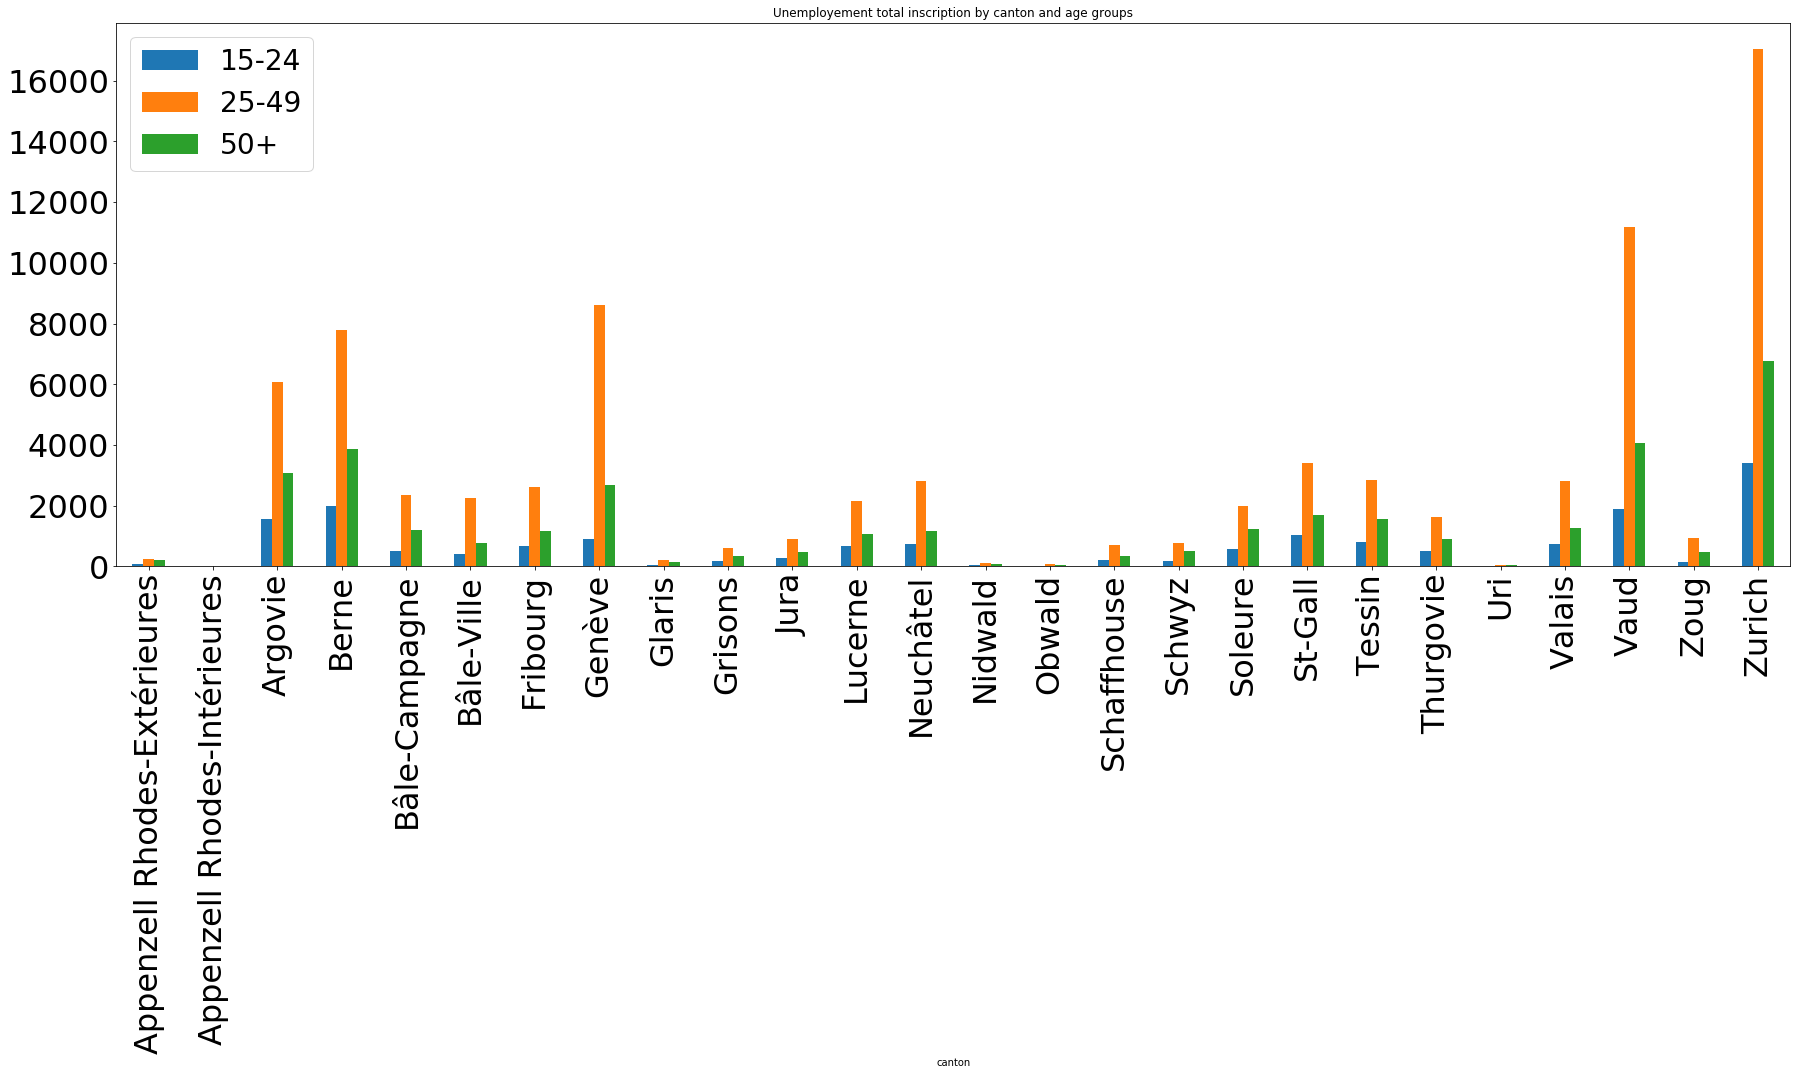

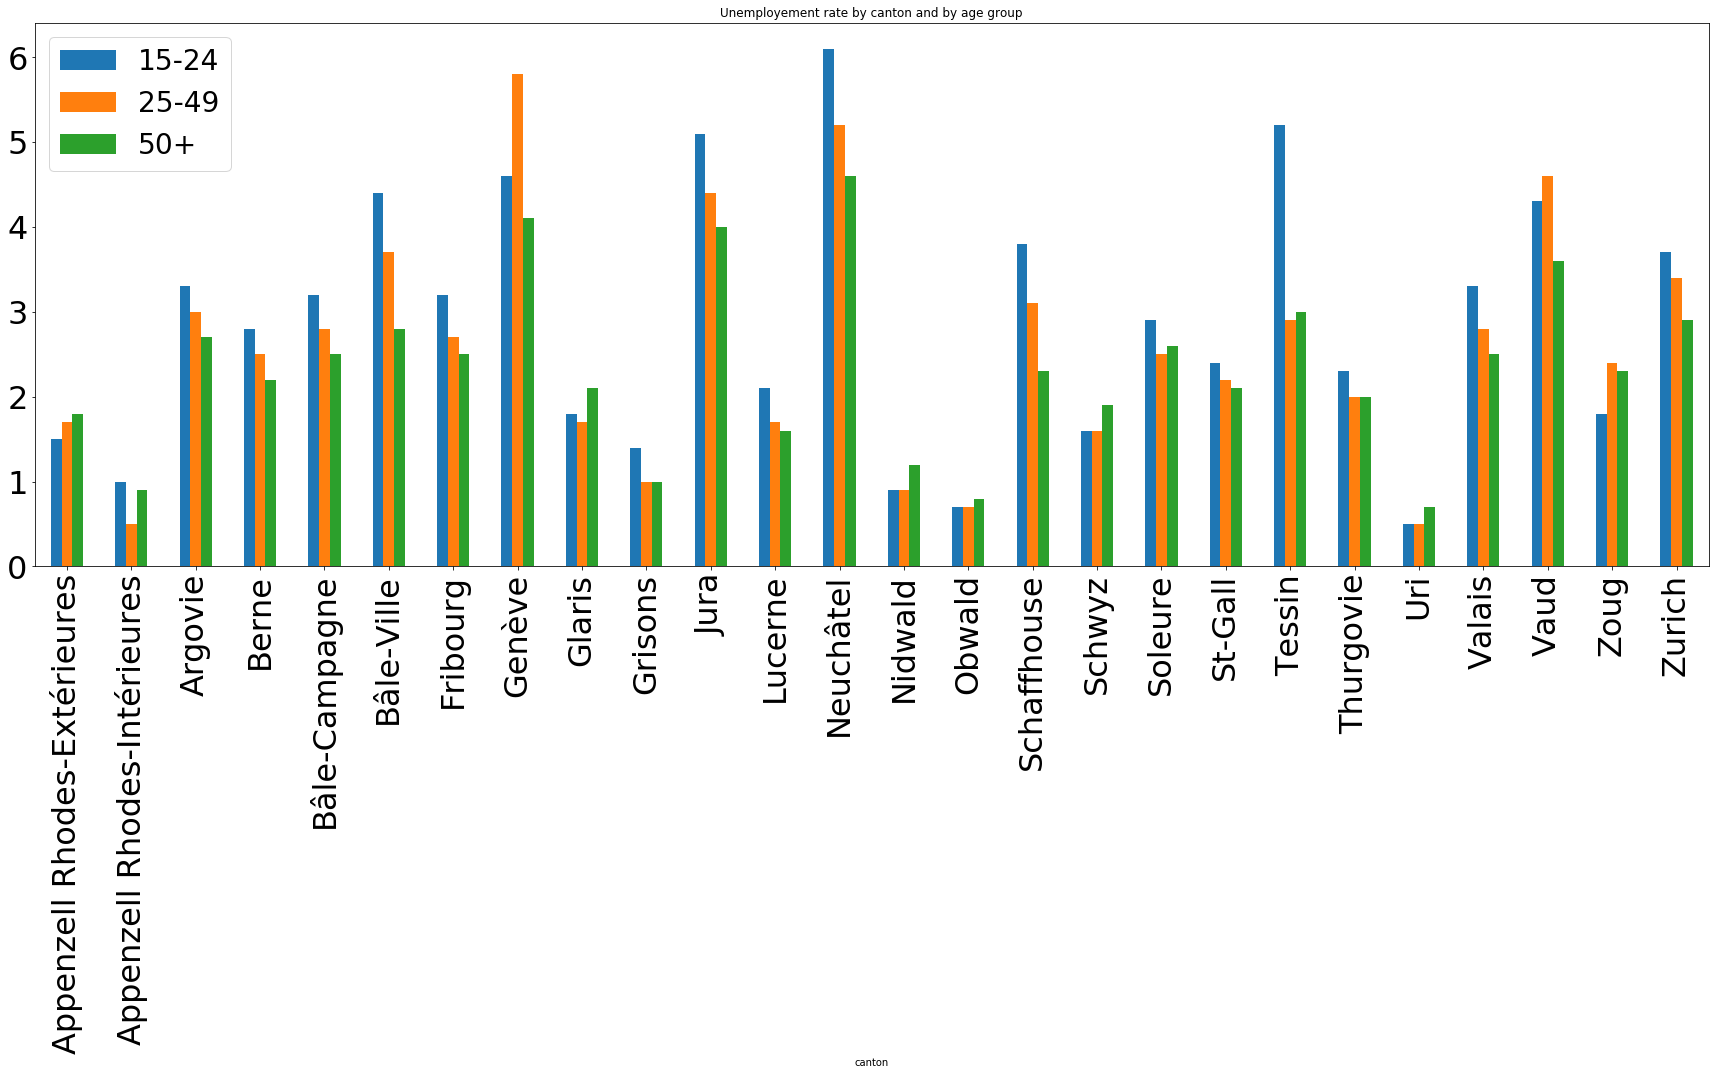

In [153]:
tmp = ch_total_unemployment_rate_by_ages.set_index(['canton', 'age_group'])

tmp.unstack().plot.bar(y='total', figsize=(30,10), fontsize=32, title='Unemployement total inscription by canton and age groups')
plt.legend(loc=2, prop={'size': 28})
plt.show()

tmp.unstack().plot.bar(y='rate', figsize=(30,10), fontsize=32, title='Unemployement rate by canton and by age group')
plt.legend(loc=2, prop={'size': 28})
plt.show()